## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
161772,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161774,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161775,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.000007)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 1 samples


## Set Parameters and Define Model

In [7]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [2, 3, 4]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [155.67232656478882, 1.8501038551330566, 0.05296959012880786, 0.02081236519716125, [128, 1000, 2, 32, 0.05]]
# [98.54442024230957, 1.7626943588256836, 0.06421160670330948, 0.020779257538261826, [256, 1000, 4, 32, 0.1]]
# [44.24084186553955, 2.3369486331939697, 0.06478558327639009, 0.02501131310084622, [1024, 1000, 4, 16, 0.1]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 4
HIDDEN_DIM = 16
KL_WEIGHT = .1

## Training

In [8]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(float(loss_cat))

In [9]:
def testModel(test_vae, latent_dim):
    # How many synthetic households to generate
    POP_SIZE = 100000  # Number of hh in WA

    # Generate random normal sample to represent each latent variable, for each row (different hh per row)
    np.random.seed(42)
    inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate households; each hh has unique latent input
    results = test_vae.decoder.predict([inputs, inputs[:,latent_dim:]])  # Nothing is actually in the second input
    gen_time = time.time() - start_time

    synth_hh_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)
    synth_hh_df.columns = VAR_NAMES
    
    # Get univariate and bivariate srmse for the current model
    srmse_uni = SRMSE.calculateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [10]:
# HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)

# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [11]:
# Train the model using single set of hyperparameters
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
start_time = time.time()

vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

train_time = (time.time()-start_time)
print(train_time)

Epoch 1/1000
1/1 [==============================] - 0s 381ms/step - tot_loss: 11.2607 - rec_loss: 11.1837 - kl_loss: 0.0770
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 12.1091 - rec_loss: 12.0331 - kl_loss: 0.0760
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 11.0383 - rec_loss: 10.9611 - kl_loss: 0.0772
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 11.1260 - rec_loss: 11.0498 - kl_loss: 0.0762
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 9.9740 - rec_loss: 9.9000 - kl_loss: 0.0740
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 10.7215 - rec_loss: 10.6482 - kl_loss: 0.0733
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 10.8273 - rec_loss: 10.7550 - kl_loss: 0.0723
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 10.2859 - rec_loss: 10.2139 - kl_loss: 0.0720
Epoch 9/1000
1/1 [======

1/1 [==============================] - 0s 1ms/step - tot_loss: 6.1871 - rec_loss: 5.7079 - kl_loss: 0.4792
Epoch 69/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 7.0519 - rec_loss: 6.5679 - kl_loss: 0.4840
Epoch 70/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.7597 - rec_loss: 5.2706 - kl_loss: 0.4891
Epoch 71/1000
1/1 [==============================] - 0s 60ms/step - tot_loss: 4.9284 - rec_loss: 4.4342 - kl_loss: 0.4942
Epoch 72/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.0571 - rec_loss: 4.5584 - kl_loss: 0.4987
Epoch 73/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 4.8332 - rec_loss: 4.3304 - kl_loss: 0.5028
Epoch 74/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.6609 - rec_loss: 5.1547 - kl_loss: 0.5062
Epoch 75/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 4.5578 - rec_loss: 4.0471 - kl_loss: 0.5107
Epoch 76/1000
1/1 [==========================

1/1 [==============================] - 0s 4ms/step - tot_loss: 1.6910 - rec_loss: 1.2193 - kl_loss: 0.4717
Epoch 136/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.9431 - rec_loss: 1.4755 - kl_loss: 0.4676
Epoch 137/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 2.1916 - rec_loss: 1.7272 - kl_loss: 0.4644
Epoch 138/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.2737 - rec_loss: 1.8101 - kl_loss: 0.4635
Epoch 139/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.9342 - rec_loss: 1.4707 - kl_loss: 0.4635
Epoch 140/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.5671 - rec_loss: 1.1035 - kl_loss: 0.4636
Epoch 141/1000
1/1 [==============================] - 0s 101ms/step - tot_loss: 1.5839 - rec_loss: 1.1208 - kl_loss: 0.4631
Epoch 142/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.5514 - rec_loss: 1.0894 - kl_loss: 0.4621
Epoch 143/1000
1/1 [=================

1/1 [==============================] - 0s 3ms/step - tot_loss: 0.8016 - rec_loss: 0.4366 - kl_loss: 0.3650
Epoch 203/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.7878 - rec_loss: 0.4264 - kl_loss: 0.3614
Epoch 204/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.8443 - rec_loss: 0.4869 - kl_loss: 0.3574
Epoch 205/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.2259 - rec_loss: 0.8726 - kl_loss: 0.3533
Epoch 206/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.8579 - rec_loss: 0.5063 - kl_loss: 0.3516
Epoch 207/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.7816 - rec_loss: 0.4319 - kl_loss: 0.3497
Epoch 208/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.2564 - rec_loss: 0.9090 - kl_loss: 0.3474
Epoch 209/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8663 - rec_loss: 0.5186 - kl_loss: 0.3477
Epoch 210/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.8869 - rec_loss: 0.6022 - kl_loss: 0.2847
Epoch 270/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.0083 - rec_loss: 0.7231 - kl_loss: 0.2852
Epoch 271/1000
1/1 [==============================] - 0s 53ms/step - tot_loss: 0.5716 - rec_loss: 0.2829 - kl_loss: 0.2887
Epoch 272/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.5758 - rec_loss: 0.2843 - kl_loss: 0.2915
Epoch 273/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.5362 - rec_loss: 0.2426 - kl_loss: 0.2936
Epoch 274/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.5186 - rec_loss: 0.2236 - kl_loss: 0.2950
Epoch 275/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.5990 - rec_loss: 0.3034 - kl_loss: 0.2956
Epoch 276/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.7250 - rec_loss: 0.4291 - kl_loss: 0.2959
Epoch 277/1000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.4332 - rec_loss: 0.2214 - kl_loss: 0.2118
Epoch 337/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.3787 - rec_loss: 0.1677 - kl_loss: 0.2110
Epoch 338/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.3498 - rec_loss: 0.1399 - kl_loss: 0.2099
Epoch 339/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 0.3731 - rec_loss: 0.1648 - kl_loss: 0.2084
Epoch 340/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.4448 - rec_loss: 0.2382 - kl_loss: 0.2066
Epoch 341/1000
1/1 [==============================] - 0s 56ms/step - tot_loss: 0.3523 - rec_loss: 0.1472 - kl_loss: 0.2051
Epoch 342/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.4623 - rec_loss: 0.2590 - kl_loss: 0.2033
Epoch 343/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3616 - rec_loss: 0.1596 - kl_loss: 0.2020
Epoch 344/1000
1/1 [==================

1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2831 - rec_loss: 0.0954 - kl_loss: 0.1877
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3013 - rec_loss: 0.1155 - kl_loss: 0.1858
Epoch 405/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3092 - rec_loss: 0.1255 - kl_loss: 0.1837
Epoch 406/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2938 - rec_loss: 0.1122 - kl_loss: 0.1815
Epoch 407/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 0.3189 - rec_loss: 0.1397 - kl_loss: 0.1792
Epoch 408/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2941 - rec_loss: 0.1172 - kl_loss: 0.1769
Epoch 409/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3023 - rec_loss: 0.1277 - kl_loss: 0.1745
Epoch 410/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3009 - rec_loss: 0.1288 - kl_loss: 0.1722
Epoch 411/1000
1/1 [===================

1/1 [==============================] - 0s 974us/step - tot_loss: 0.2602 - rec_loss: 0.0792 - kl_loss: 0.1811
Epoch 470/1000
1/1 [==============================] - 0s 985us/step - tot_loss: 0.2603 - rec_loss: 0.0751 - kl_loss: 0.1851
Epoch 471/1000
1/1 [==============================] - 0s 58ms/step - tot_loss: 0.2748 - rec_loss: 0.0863 - kl_loss: 0.1885
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3183 - rec_loss: 0.1271 - kl_loss: 0.1913
Epoch 473/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2814 - rec_loss: 0.0877 - kl_loss: 0.1937
Epoch 474/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2938 - rec_loss: 0.0982 - kl_loss: 0.1956
Epoch 475/1000
1/1 [==============================] - 0s 967us/step - tot_loss: 0.3038 - rec_loss: 0.1067 - kl_loss: 0.1971
Epoch 476/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.3475 - rec_loss: 0.1492 - kl_loss: 0.1982
Epoch 477/1000
1/1 [============

1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2949 - rec_loss: 0.0624 - kl_loss: 0.2325
Epoch 537/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.3039 - rec_loss: 0.0724 - kl_loss: 0.2315
Epoch 538/1000
1/1 [==============================] - 0s 952us/step - tot_loss: 0.2991 - rec_loss: 0.0688 - kl_loss: 0.2304
Epoch 539/1000
1/1 [==============================] - 0s 928us/step - tot_loss: 0.2845 - rec_loss: 0.0554 - kl_loss: 0.2291
Epoch 540/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2800 - rec_loss: 0.0524 - kl_loss: 0.2276
Epoch 541/1000
1/1 [==============================] - 0s 65ms/step - tot_loss: 0.3288 - rec_loss: 0.1027 - kl_loss: 0.2260
Epoch 542/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2946 - rec_loss: 0.0701 - kl_loss: 0.2245
Epoch 543/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2827 - rec_loss: 0.0598 - kl_loss: 0.2229
Epoch 544/1000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2107 - rec_loss: 0.0518 - kl_loss: 0.1588
Epoch 603/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2311 - rec_loss: 0.0731 - kl_loss: 0.1580
Epoch 604/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2040 - rec_loss: 0.0468 - kl_loss: 0.1572
Epoch 605/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2031 - rec_loss: 0.0468 - kl_loss: 0.1563
Epoch 606/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2142 - rec_loss: 0.0589 - kl_loss: 0.1553
Epoch 607/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.6857 - rec_loss: 0.5315 - kl_loss: 0.1542
Epoch 608/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2234 - rec_loss: 0.0672 - kl_loss: 0.1562
Epoch 609/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1986 - rec_loss: 0.0408 - kl_loss: 0.1578
Epoch 610/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2556 - rec_loss: 0.1161 - kl_loss: 0.1396
Epoch 670/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2408 - rec_loss: 0.0995 - kl_loss: 0.1413
Epoch 671/1000
1/1 [==============================] - 0s 76ms/step - tot_loss: 0.1808 - rec_loss: 0.0379 - kl_loss: 0.1429
Epoch 672/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1971 - rec_loss: 0.0529 - kl_loss: 0.1442
Epoch 673/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1882 - rec_loss: 0.0429 - kl_loss: 0.1453
Epoch 674/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.1912 - rec_loss: 0.0451 - kl_loss: 0.1461
Epoch 675/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1918 - rec_loss: 0.0452 - kl_loss: 0.1466
Epoch 676/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.3921 - rec_loss: 0.2451 - kl_loss: 0.1470
Epoch 677/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1689 - rec_loss: 0.0578 - kl_loss: 0.1111
Epoch 737/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.1653 - rec_loss: 0.0543 - kl_loss: 0.1110
Epoch 738/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2689 - rec_loss: 0.1580 - kl_loss: 0.1109
Epoch 739/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1702 - rec_loss: 0.0590 - kl_loss: 0.1112
Epoch 740/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.7334 - rec_loss: 0.6219 - kl_loss: 0.1115
Epoch 741/1000
1/1 [==============================] - 0s 89ms/step - tot_loss: 0.1456 - rec_loss: 0.0302 - kl_loss: 0.1154
Epoch 742/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.3366 - rec_loss: 0.2177 - kl_loss: 0.1189
Epoch 743/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1613 - rec_loss: 0.0383 - kl_loss: 0.1230
Epoch 744/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2403 - rec_loss: 0.0263 - kl_loss: 0.2140
Epoch 804/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2410 - rec_loss: 0.0264 - kl_loss: 0.2146
Epoch 805/1000
1/1 [==============================] - 0s 947us/step - tot_loss: 0.2512 - rec_loss: 0.0363 - kl_loss: 0.2149
Epoch 806/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2419 - rec_loss: 0.0271 - kl_loss: 0.2148
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2454 - rec_loss: 0.0310 - kl_loss: 0.2144
Epoch 808/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 0.2354 - rec_loss: 0.0216 - kl_loss: 0.2138
Epoch 809/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2338 - rec_loss: 0.0209 - kl_loss: 0.2128
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2552 - rec_loss: 0.0435 - kl_loss: 0.2116
Epoch 811/1000
1/1 [=================

1/1 [==============================] - 0s 4ms/step - tot_loss: 0.1519 - rec_loss: 0.0287 - kl_loss: 0.1232
Epoch 871/1000
1/1 [==============================] - 0s 58ms/step - tot_loss: 0.1477 - rec_loss: 0.0250 - kl_loss: 0.1227
Epoch 872/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1529 - rec_loss: 0.0306 - kl_loss: 0.1222
Epoch 873/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1522 - rec_loss: 0.0305 - kl_loss: 0.1216
Epoch 874/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1455 - rec_loss: 0.0245 - kl_loss: 0.1210
Epoch 875/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1418 - rec_loss: 0.0215 - kl_loss: 0.1203
Epoch 876/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1492 - rec_loss: 0.0297 - kl_loss: 0.1195
Epoch 877/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1420 - rec_loss: 0.0233 - kl_loss: 0.1187
Epoch 878/1000
1/1 [==================

1/1 [==============================] - 0s 5ms/step - tot_loss: 0.1574 - rec_loss: 0.0458 - kl_loss: 0.1115
Epoch 938/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1677 - rec_loss: 0.0564 - kl_loss: 0.1113
Epoch 939/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2422 - rec_loss: 0.1311 - kl_loss: 0.1111
Epoch 940/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1400 - rec_loss: 0.0285 - kl_loss: 0.1115
Epoch 941/1000
1/1 [==============================] - 0s 112ms/step - tot_loss: 0.1395 - rec_loss: 0.0279 - kl_loss: 0.1117
Epoch 942/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1500 - rec_loss: 0.0383 - kl_loss: 0.1117
Epoch 943/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1379 - rec_loss: 0.0262 - kl_loss: 0.1117
Epoch 944/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1451 - rec_loss: 0.0336 - kl_loss: 0.1115
Epoch 945/1000
1/1 [=================

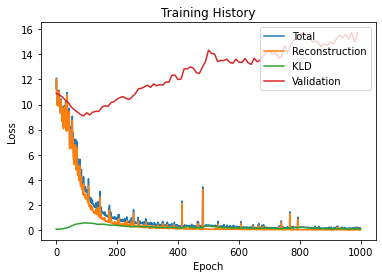

In [12]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

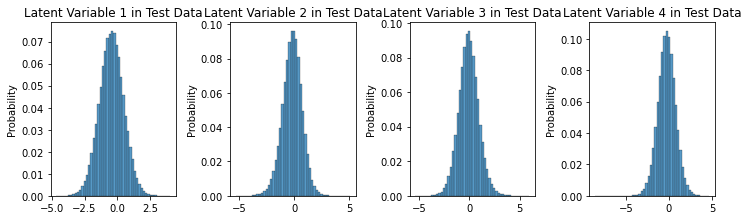

In [13]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [14]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 15.487813949584961


In [15]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [16]:
# How many synthetic households to generate
POP_SIZE = 100000  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

start_time = time.time()

# Generate households; each hh has unique latent input
results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

--- 2.9599125385284424 seconds ---


In [17]:
# Save raw output values to be conditional inputs for the person CVAE
synth_hh_ohe_df = pd.DataFrame()
synth_hh_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_ohe, 1, x)  # Most variables in PUMS are indexed from 1
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_ohe_df = pd.concat([synth_hh_ohe_df, result_df], axis=1)
    
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)

synth_hh_df.columns = VAR_NAMES

synth_hh_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
synth_hh_ohe_df.to_csv('data/synthetic_populations/wa_households_raw.csv', index=False)

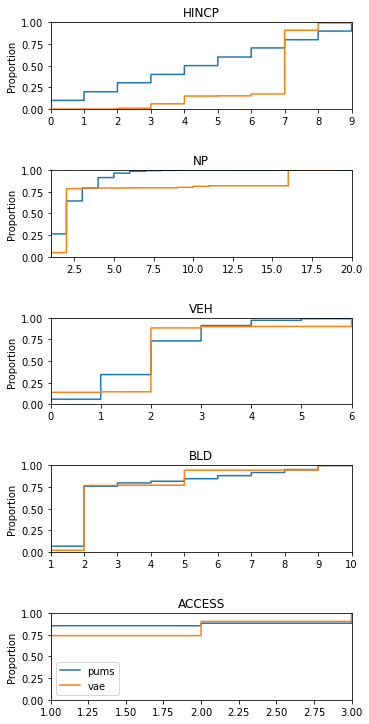

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_hh_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

In [19]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.45039491888600786
Bivariate (joint) SRMSE: 0.23256314111991913


(2.6496195793151855, 0.45039491888600786, 0.23256314111991913)